In [1]:
## Behaviour Cloning

batch_size = int(1)
displaly_size = int(10)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


In [2]:
import os
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import cv2

class action_dataset(Dataset):
    """Monet dataset."""
    def __init__(self, path, transform=None):
        """
        Args:
            path_X (string): Path to the X images directory.
            path_Y (string): Path to the Y images directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_path = path
        self.transform = transform
        self.list =  os.listdir(path)
        self.batch_size =1
        self.classes = 4

    def __len__(self):
        return len(self.list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_path,
                                self.list[idx])
        image = cv2.imread(img_name)
#         label = 
#         print(self.list[idx].strip('.jpg')[-1])
        idx = torch.LongTensor([[float(self.list[idx].strip('.jpg')[-1])]])#
        hot_vec = hot_v = torch.zeros(self.batch_size, self.classes)
        hot_vec.scatter_(1, idx, 1.0)
        hot_vec

        if self.transform:
            image = self.transform(image)

        return image,hot_vec

In [3]:
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

torch.Size([1, 4])


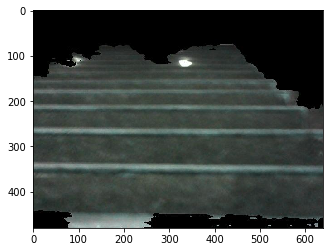

In [5]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
#     img = img.cpu()
#     npimg = img.detach().numpy()
    plt.imshow(torchvision.utils.make_grid(np.transpose(img, (1, 2, 0))))
    plt.show()
    
# Create datasets
trainset = action_dataset('data/new_dataset/image_mask/', data_transform)
valset = action_dataset('data/new_dataset/val/', data_transform)
a = trainset[109]
print(a[1].shape)
imshow(a[0])

In [6]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.lyr1 = nn.Sequential(nn.Conv2d(3, 36, kernel_size = 5, stride = 2), nn.BatchNorm2d(36), nn.ELU())
        self.lyr2 = nn.Sequential(nn.Conv2d(36, 48, kernel_size = 5, stride = 2), nn.BatchNorm2d(48), nn.ELU())
        self.lyr3 = nn.Sequential(nn.Conv2d(48, 64, kernel_size = 5, stride = 2), nn.BatchNorm2d(64), nn.ELU())
        self.lyr4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size = 3), nn.BatchNorm2d(64), nn.ELU())
        self.lyr5 = nn.Sequential(nn.Conv2d(64, 64, kernel_size = 3), nn.BatchNorm2d(64), nn.ELU())

        self.fc1 = nn.Sequential(nn.Linear(64*73*53, 100), nn.ELU())
        self.fc2 = nn.Sequential(nn.Linear(100, 50), nn.ELU())
        self.fc3 = nn.Sequential(nn.Linear(50, 10), nn.ELU())
        self.fc4 = nn.Linear(10, 4)
#         self.fc5 = nn.Linear(4, 1)

    def forward(self, x):
        out = self.lyr1(x)
        out = self.lyr2(out)
        out = self.lyr3(out)
        out = self.lyr4(out)
        out = self.lyr5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
#         out = self.fc5(out)
        return out


In [7]:
#instanciate cloner
# cl = cloner()
cl2 = CNN()
cl2 = torch.load('model/model_best.pth')
# cl = cl.cuda()

In [8]:
ip = torch.randn(batch_size,3,480,640)
la = torch.randn(batch_size,4)
# la = torch.tensor(la, dtype=torch.long)

In [9]:
cl2(ip)
losses_tr = np.empty((1,1))
losses_val =np.empty((1,1))

In [12]:
#create optimization function and loss function for both generator and discriminator
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(cl2.parameters(), lr=0.0002, betas = (0.5,0.999))

In [ ]:
# Trainer

In [13]:
#Trainer
last_loss = 0.0
for epoch in range(20):

    loss = 0.0
    running_loss = 0.0
    avg = 0.0
    for i in range(len(trainset)):
        print('-',end='')
        # get the inputs 
        ip[0], la[:,:] = trainset[i][0], trainset[i][1]
        
#         ip = ip.cuda()
        
        #Minimize discriminator loss against ones
        action = cl2(ip)
        loss_1 = criterion(action, la)
        loss_1.backward()
        optimizer.step()
        
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        # print statistics
        running_loss += loss_1.item()
        
        i += 1;
        
        if i % 50 == 49:    # print every 2000 mini-batches
            print('>',end='')
            
            print('Epoch: %d | No of images: %5d | loss: %.3f ' %
                  (epoch + 1, i + 1, running_loss / 50))
            losses_tr = np.append(losses_tr, running_loss)
            running_loss = 0.0 
    
    loss = 0.0
    running_loss = 0.0
    
    print('Validating')
    
    for i in range(len(valset)):
        print('-',end='')
        # get the inputs 
        ip[0], la[:,:] = valset[i][0], valset[i][1]

        action = cl2(ip)
        loss_1 = criterion(action, la)
       # print statistics
        running_loss += loss_1.item()
        avg += loss_1.item()

        i += 1;

        if i % 100 == 99:    # print every 2000 mini-batches
            print('>',end='')

            print('Epoch: %d | No of images: %5d | loss: %.3f ' %
                  (epoch + 1, i + 1, running_loss / 100))
            losses_val = np.append(losses_val, running_loss)
            running_loss = 0.0 
            
    if last_loss == 0 or avg < last_loss:
            torch.save(cl2,  'model/model_best.pth')
            last_loss = avg

            
print('Finished Training')

------------------------------------------------->Epoch: 1 | No of images:    50 | loss: 0.496 
-------------------------------------------------->Epoch: 1 | No of images:   100 | loss: 0.175 
-------------------------------------------------->Epoch: 1 | No of images:   150 | loss: 0.165 
-------------------------------------------------->Epoch: 1 | No of images:   200 | loss: 0.139 
-------------------------------------------------->Epoch: 1 | No of images:   250 | loss: 0.147 
-------------------------------------------------->Epoch: 1 | No of images:   300 | loss: 0.143 
-------------------------------------------------->Epoch: 1 | No of images:   350 | loss: 0.120 
-------------------------------------------------->Epoch: 1 | No of images:   400 | loss: 0.108 
-------------------------------------------------->Epoch: 1 | No of images:   450 | loss: 0.135 
-------------------------------------------------->Epoch: 1 | No of images:   500 | loss: 0.147 
-------------------------------

/home/rex/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


------------------------------------------------->Epoch: 2 | No of images:    50 | loss: 0.126 
-------------------------------------------------->Epoch: 2 | No of images:   100 | loss: 0.116 
-------------------------------------------------->Epoch: 2 | No of images:   150 | loss: 0.100 
-------------------------------------------------->Epoch: 2 | No of images:   200 | loss: 0.106 
-------------------------------------------------->Epoch: 2 | No of images:   250 | loss: 0.072 
-------------------------------------------------->Epoch: 2 | No of images:   300 | loss: 0.096 
-------------------------------------------------->Epoch: 2 | No of images:   350 | loss: 0.092 
-------------------------------------------------->Epoch: 2 | No of images:   400 | loss: 0.064 
-------------------------------------------------->Epoch: 2 | No of images:   450 | loss: 0.080 
-------------------------------------------------->Epoch: 2 | No of images:   500 | loss: 0.117 
-------------------------------

-------------------------------------------------->Epoch: 8 | No of images:   400 | loss: 0.010 
-------------------------------------------------->Epoch: 8 | No of images:   450 | loss: 0.018 
-------------------------------------------------->Epoch: 8 | No of images:   500 | loss: 0.022 
-------------------------------------------------->Epoch: 8 | No of images:   550 | loss: 0.021 
---------------------Validating
--------------------------------------------------------------------------------------------------->Epoch: 8 | No of images:   100 | loss: 0.060 
----------------------------------------------------------->Epoch: 9 | No of images:    50 | loss: 0.020 
-------------------------------------------------->Epoch: 9 | No of images:   100 | loss: 0.006 
-------------------------------------------------->Epoch: 9 | No of images:   150 | loss: 0.007 
-------------------------------------------------->Epoch: 9 | No of images:   200 | loss: 0.019 
-------------------------------------

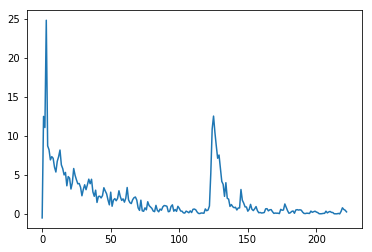

In [16]:
import matplotlib.pyplot as plt
plt.plot(losses_tr)

5.487836919433903


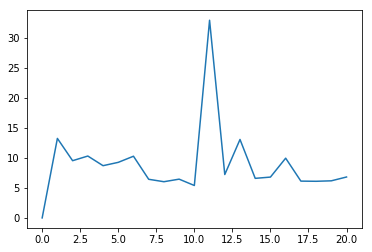

In [21]:
plt.plot(losses_val)
print(last_loss)
np.save('val_losses',losses_val)
np.save('tr_losses',losses_tr)

In [25]:
a = np.load('tr_losses.npy')


In [ ]:
# import numpy as np

# import os
# import sys
# try:
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
# except:
#     pass

# import cv2 as cv

# PATH_IMG = '/home/rex/test/new_dataset/image/image/image'
# PATH_MASK = '/home/rex/test/new_dataset/mask/'
# OUT_FOLDER = '/home/rex/test/new_dataset/here/'

# for i in os.listdir(PATH_IMG):
#     img, mask = cv.imread(f'{PATH_IMG}/{i}'), cv.imread(f'{PATH_MASK}/{i}')
#     masked_image = np.multiply(img, mask/255)
#     cv.imwrite(f'{OUT_FOLDER}/{i}', masked_image)
losses_tr

In [ ]:
import cv2 as cv
import numpy as np
import argparse
import os
import json


def disp_mask(image = None, Mask = None):

    alpha = 0.5
    try:
        image = args.image
        mask = args.mask
        print('--------------------------------')

    except:
        pass

    image = cv.imread(image)
    mask = np.load(mask)

    if image is None:
        print("Error loading src1")
        exit(-1)
    elif mask is None:
        print("Error loading src2")
        exit(-1)
    mask[:,:,1] = 0;
    seg = cv.addWeighted(image, alpha, mask, (1-alpha), 0.0)
    cv.imshow('Segmented', seg)
    cv.waitKey(0)
    cv.destroyAllWindows()


def get_mask(img,file):

#     if not os.path.exists(args.directory):
#         os.mkdir(args.directory)
#         print('Created out_dir')

#     for name in os.listdir(args.input_image):
        frame = cv.imread(img)#args.input_image + '/' + name)
        with open(str(file)) as json_file:
            data = json.load(json_file)
        key_points = data['shapes'][0]['points']
        mask = np.zeros(frame.shape, np.uint8)
        cv.fillPoly(mask, np.int32([np.array(key_points)]), color = (255,255,255))
        # cv.imshow('temp',mask)
        return mask
#         cv.imshow('k',mask)
#         cv.waitKey(0)
#         cv.destroyAllWindows()
#         cv.imwrite(args.directory + '/' + name, mask)


if __name__ == "__get_mask__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-d", "--directory", type=str, help="Path to save the images")
    parser.add_argument("-ia", "--input_annotations", type=str, help="Bag file to read")
    parser.add_argument("-ii", "--input_image", type=str, help="Bag file to read")
    args = parser.parse_args()

if __name__ == "__disp_mask__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--image", type=str, help="path/image")
    parser.add_argument("-m", "--mask", type=str, help="path/mask")
    parser.add_argument("-a", "--alpha", type=int, help="alpha")
    args = parser.parse_args()

In [ ]:
import torchvision
import numpy as np
import time
from fastai.vision import *

# from sensor_msgs.msg import CompressedImage


#!/usr/bin/env python
# import rospy

import sys

try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
except:
    pass
import os
import cv2 as cv
import torch
from torch.autograd.variable import Variable
from torchvision.transforms import Normalize
import sys
import numpy as np
from PIL import Image

imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# try:
#     sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')   # It causes cv2 import error
# except:
#     print('yeah!')


path_mask = '../new_dataset/mask/'
path_img_mask = '../new_dataset/image_mask/'
path_img = '/home/rex/test/new_dataset/image/image/image/'
def preprocess(images):
    images = torch.unsqueeze(torch.from_numpy(images),dim=0)
    images = images.float()
    images = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(images)
    return images#.half()

def get_subtracted(images):
    images = images.view(images.size(0)/2, 2, 3, 480, 640)
    images1, images2 = images[:,0], images[:,1]
    return images1-images2

def get_masked(img, mask):
    masked_image = np.multiply(img, mask/255)
    return masked_image

def getnp(mat):
    mat = mat.cpu()
    return mat.detach().numpy()


seg_learner_path = '../stairnet/models/segmentation_model/'
seg_learn = load_learner(seg_learner_path).to_fp32()
#     list = os.listdir(path_img)
#     print('Press Ctrl+C for exiting')
#     for name in list:
def get_predict(img,save):
    test_image = open_image(img)
    img_segment = seg_learn.predict(test_image)[0]
    torchvision.utils.save_image(img_segment.data,save)
    return cv.imread(save)
#     masked = np.multiply(test_image.data, img_segment.data)
#     torchvision.utils.save_image(masked, save2)
    print('.')

In [ ]:
k = 5
a = 0

In [ ]:
# def get_iou():
for k in range(1,2):
    real = get_mask('/home/rex/test/stairnet/data/stairtestset/adversaries/'+str(k)+'.jpg','/home/rex/test/stairnet/data/stairtestset/adversaries/'+str(k)+'.json')
    fake = (get_predict('/home/rex/test/stairnet/data/stairtestset/adversaries/'+str(k)+'.jpg','/home/rex/test/stairnet/data/stairtestset/result/this.jpg'))/255
    real = cv.resize(real,(640, 480) )#.transpose(1,0,2)
#     print(fake.shape)
#     print(real.shape)
    print(k)
    a = a + get_iou(real,fake)
    

In [ ]:
import numpy as np
def get_iou(real,fake):
    intersection = np.multiply(real,fake)/255
    union = np.logical_or(fake,real)
#     print(intersection[22][221], np.sum(intersection),np.sum(union))
    return np.sum(intersection)/np.sum(union)

In [ ]:
a = get_iou(real,fake)

In [ ]:
temp = a

In [ ]:
temp

In [ ]:
a/2


In [ ]:
cv.imshow('k',fake)
cv.waitKey(3000)
cv.destroyAllWindows()


In [ ]:
cv.imshow('k',real)
cv.waitKey(3000)
cv.destroyAllWindows()


In [ ]:
    real.shape

In [ ]:
fake.shape

In [ ]:
cv.imwrite('/home/rex/test/stairnet/data/stairtestset/adversaries/mask1.jpg',fake)

In [ ]:
indices = torch.LongTensor(1,7,5).view(-1,1)
one_hot = torch.zeros(3, 10)
one_hot.scatter(2, indices, 1)

In [ ]:
import torch


In [ ]:
a = torch.zeros((1,1))

In [ ]:
a = 1

In [ ]:
a.size(2)

In [ ]:
a

In [ ]:
a.data

In [ ]:
#Generator model 


class Generator(nn.Module):
    def __init__(self):
        
        super(Generator, self).__init__()
        
        
        ## input > ENCODER > RESNET nine times > DECODER > output
        
        self.encode = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size = (7), stride= 1, padding = 2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = (3), stride= 2, padding = 0),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = (3), stride= 2, padding = 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        )
        
        self.resnet = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = (1), stride= 1),
            nn.BatchNorm2d(256),            
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = (3), stride= 1, padding=1),
            nn.BatchNorm2d(256),            
        )
        
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride= 2),      
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride= 2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size = (7), stride= 1),
            nn.InstanceNorm2d(3),
            nn.ReLU(),
        )
        
        
    def forward(self, x):
        x = self.encode(x);
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = self.decode(x);
        
        return x

In [12]:


class cloner(nn.Module):
    def __init__(self):
        
        super(cloner, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 4, stride= 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size = 4, stride= 2),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size = 4, stride= 2),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size = 4, stride= 2),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 256, kernel_size = 14, stride= 1),  #Apply conv to get one dimensional output
            nn.Conv2d(256, 1, kernel_size = 4, stride= 1),
#             nn.InstanceNorm2d(512),
#             nn.LeakyReLU(0.2),
            
        )

    def forward(self, x):
      
        x = self.block(x);
        x = x.view(22*12)
        x = nn.Linear(22*12, 12)(x)
        x = nn.Linear(12, 1)(x)
        
        return x   


In [13]:
######## Testing ##############

In [36]:
confusion_mat = torch.zeros((4,4))
ip = torch.randn(batch_size,3,480,640)
act_true = torch.randn(batch_size,4)

In [37]:
for i in range(len(valset)):
        print('-',end='')
        ip[0], act_true[:,:] = valset[i][0], valset[i][1]
        act_predicted = cl2(ip)
        vert = np.argmax(act_true.detach().numpy())
        hor = np.argmax(act_predicted.detach().numpy())
        confusion_mat[vert][hor] = confusion_mat[vert][hor] + 1;

-------------------------------------------------------------------------------------------------------------

In [29]:
import numpy as np
a = np.argmax(act_true)

In [38]:
confusion_mat

tensor([[52.,  0.,  0.,  1.],
        [ 0., 17.,  1.,  0.],
        [ 1.,  8., 29.,  0.],
        [ 0.,  0.,  0.,  0.]])

In [31]:
act_true

tensor([[-0.6587,  0.0926,  0.5410,  0.1812]])

In [ ]:
# Try lear ide mappig usig o liear layers

In [16]:
#cloner model 
import torch.nn as nn
import torch.nn.functional as F


In [17]:
confusion_mat = torch.zeros((4,4))
ip = torch.randn(batch_size,3,480,640)
act_true = torch.randn(batch_size,4)
losses_res = np.empty((1,1))
losses_pla =np.empty((1,1))

In [22]:
# residual model 
import torch.nn as nn

class ide_res(nn.Module):
    def __init__(self):
        
        super(ide_res, self).__init__()
        
        
        ## input > ENCODER > RESNET nine times > DECODER > output
        
        self.encode = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size = (7), stride= 1, padding = 2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = (3), stride= 2, padding = 0),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = (3), stride= 2, padding = 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        )
        
        self.resnet = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = (1), stride= 1),
            nn.BatchNorm2d(256),            
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = (3), stride= 1, padding=1),
            nn.BatchNorm2d(256),            
        )
        
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride= 2),      
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride= 2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size = (7), stride= 1),
            nn.InstanceNorm2d(3),
            nn.ReLU(),
        )
        
        
    def forward(self, x):
        x = self.encode(x);
        x = F.relu(x + self.resnet(x));
#         x = F.relu(x + self.resnet(x));
#         x = F.relu(x + self.resnet(x));
#         x = F.relu(x + self.resnet(x));
#         x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = F.relu(x + self.resnet(x));
        x = self.decode(x);
        
        return x

In [23]:
#plai model 
import torch.nn as nn
import torch.nn.functional as F


class ide_pla(nn.Module):
    def __init__(self):
        super(ide_pla, self).__init__()
        self.encode = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size = (7), stride= 1, padding = 2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = (3), stride= 2, padding = 0),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = (3), stride= 2, padding = 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        )
        
        self.resnet = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = (1), stride= 1),
            nn.BatchNorm2d(256),            
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size = (3), stride= 1, padding=1),
            nn.BatchNorm2d(256),            
        )
        
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride= 2),      
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride= 2),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size = (7), stride= 1),
            nn.InstanceNorm2d(3),
            nn.ReLU(),
        )
        
        
    def forward(self, x):
        x = self.encode(x);
        x = F.relu(self.resnet(x));
#         x = F.relu(self.resnet(x));
#         x = F.relu(self.resnet(x));
#         x = F.relu(self.resnet(x));
#         x = F.relu(self.resnet(x));
        x = F.relu(self.resnet(x));
        x = F.relu(self.resnet(x));
        x = F.relu(self.resnet(x));
        x = F.relu(self.resnet(x));
        x = self.decode(x);
        
        return x


In [24]:
ip = torch.randn(batch_size,3,480,640)
la = torch.randn(batch_size,4)
# la = torch.tensor(la, dtype=torch.long)
ip[0], la[:,:] = valset[0][0], valset[0][1]
model_res = ide_res()
model_pla = ide_pla()
out_res = model_res(ip)
out_pla = model_pla(ip)
print(out_res.shape, out_pla.shape, ip.shape)


torch.Size([1, 3, 480, 640]) torch.Size([1, 3, 480, 640]) torch.Size([1, 3, 480, 640])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


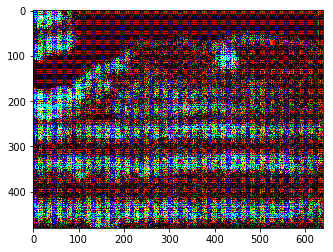

In [26]:
imshow(out_pla.detach()[0])
#create optimization function and loss function for both generator and discriminator
import torch.optim as optim

criterion = nn.MSELoss()
optimizer_pla = optim.Adam(model_pla.parameters(), lr=0.0002, betas = (0.5,0.999))
optimizer_res = optim.Adam(model_res.parameters(), lr=0.0002, betas = (0.5,0.999))

In [27]:
#Trainer
last_loss = 0.0
for epoch in range(20):

    loss = 0.0
    running_loss = 0.0
    avg = 0.0
    for i in range(len(trainset)):
        print('-',end='')
        # get the inputs 
        ip[0], la[:,:] = trainset[i][0], valset[i][1]
        
#         ip = ip.cuda()
        
        #Minimize discriminator loss against ones
        model_res = ide_res()
        model_pla = ide_pla()
        out_res = model_res(ip)
        out_pla = model_pla(ip)
        
        loss_res = criterion(out_res, ip)
        loss_pla = criterion(out_pla, ip)
        loss_res.backward()
        optimizer_res.step()
        loss_pla.backward()
        optimizer_pla.step()
        
        
        # zero the parameter gradients
        optimizer_pla.zero_grad()
        optimizer_res.zero_grad()
        
        
        # print statistics
        running_loss_pla += loss_pla.item()
        running_loss_res += loss_res.item()
        
        i += 1;
        
        if i % 50 == 49:    # print every 2000 mini-batches
            print('>',end='')
            
            print('Epoch: %d | No of images: %5d | loss_res: %.3f | loss_pla: %.3f' %
                  (epoch + 1, i + 1, running_loss_res / 50, running_loss_pla / 50))
            losses_tr_res = np.append(losses_tr_res, running_loss_res)
            running_loss_res = 0.0
            losses_tr_pla = np.append(losses_tr_pla, running_loss_pla)
            running_loss_pla = 0.0 
    
    
    loss_res = 0.0
    running_loss_res = 0.0
    loss_pla = 0.0
    running_res = 0.0
    
            
print('Finished Training')

-

NameError: name 'running_loss_pla' is not defined

NameError: name 'last_loss' is not defined

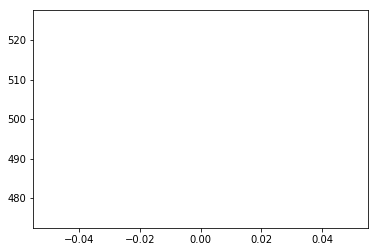

In [36]:
plt.plot(losses_val)
print(last_loss)
np.save('val_losses_ide',losses_val)
np.save('tr_losses_ide',losses_tr)